In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy import stats
from fbprophet import Prophet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sb.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv('data/data.csv')
df.head().T

,0,1,2,3,4
house_pk,84561,84561,84561,84561,84561
agency_id,90,90,90,90,90
date_in,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23
price,532,588,588,588,588
dis_water_real,0.261,0.261,0.261,0.261,0.261
dis_shopping,3,3,3,3,3
no_bedrooms,3,3,3,3,3
max_persons,4,4,4,4,4
house_size,140,140,140,140,140
land_size,726,726,726,726,726


# Datetime

Linear regression can't work with date thim. Thats why we need to convert the datetime into year, month and day

In [3]:
df['date_in'] = pd.to_datetime(df['date_in'])
df['year'] = df['date_in'].map(lambda x: x.strftime('%Y'))
df['month'] = df['date_in'].map(lambda x: x.strftime('%m'))
df['day'] = df['date_in'].map(lambda x: x.strftime('%d'))

df.head().T

,0,1,2,3,4
house_pk,84561,84561,84561,84561,84561
agency_id,90,90,90,90,90
date_in,2016-08-27 00:00:00,2016-08-26 00:00:00,2016-08-25 00:00:00,2016-08-24 00:00:00,2016-08-23 00:00:00
price,532,588,588,588,588
dis_water_real,0.261,0.261,0.261,0.261,0.261
dis_shopping,3,3,3,3,3
no_bedrooms,3,3,3,3,3
max_persons,4,4,4,4,4
house_size,140,140,140,140,140
land_size,726,726,726,726,726


# Categorical Features Convert

We have categorical data in our dataset. For linear regression we need to handle these kinds of data

In [4]:
categorical_features = ['agency_id', 'apartment', 'indoor_pool', 'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'year', 'month', 'day', 'build_year', 'renovation_year']

label_encoders = {}
for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        df[cat_col] = label_encoders[cat_col].fit_transform(df[cat_col])

dk = df
df.head().T

,0,1,2,3,4
house_pk,84561,84561,84561,84561,84561
agency_id,0,0,0,0,0
date_in,2016-08-27 00:00:00,2016-08-26 00:00:00,2016-08-25 00:00:00,2016-08-24 00:00:00,2016-08-23 00:00:00
price,532,588,588,588,588
dis_water_real,0.261,0.261,0.261,0.261,0.261
dis_shopping,3,3,3,3,3
no_bedrooms,3,3,3,3,3
max_persons,4,4,4,4,4
house_size,140,140,140,140,140
land_size,726,726,726,726,726


# Target Value

Lets analyse the target value and see the correlation with other variables.

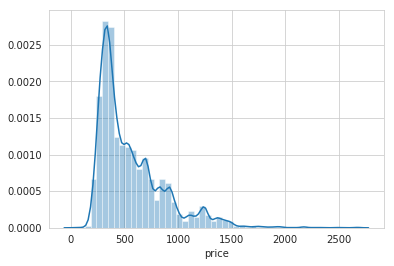

In [5]:
sb.distplot(df['price'])

In [6]:
# statistics of price value

df['price'].describe()

#from the result we can see that the minimum price is 28$ and maximum price is 2688$ and the mean is 560$

count    85195.000000
mean       560.170879
std        312.439706
min         28.000000
25%        336.000000
50%        455.000000
75%        700.000000
max       2688.000000
Name: price, dtype: float64

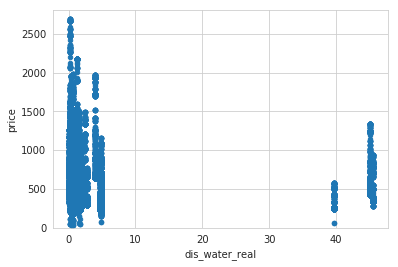

In [7]:
# correlation between 'dis_water_real' with 'price'

var = 'dis_water_real'

data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,2800))

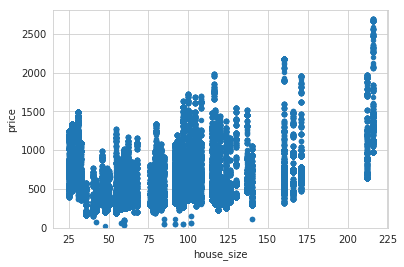

In [8]:
# correlation between 'house_size' with 'price'

var = 'house_size'

data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,2800))

#from the result we can see that most of the house's size is below 150

(-0.5, 3.5, 0, 2800)

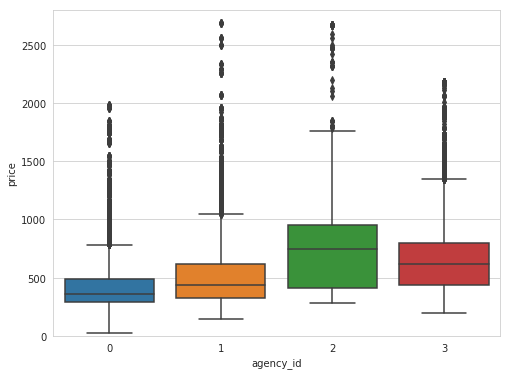

In [9]:
# correlation between 'agency_id' with 'price'

var = 'agency_id'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sb.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=2800)

(-0.5, 38.5, 0, 2800)

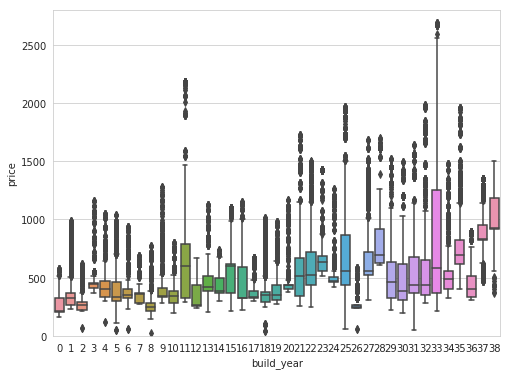

In [10]:
# correlation between 'build_year' with 'price'

var = 'build_year'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sb.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=2800)

In [11]:
# correlation with other variables

df.corr()

,house_pk,agency_id,price,dis_water_real,dis_shopping,no_bedrooms,max_persons,house_size,land_size,build_year,...,indoor_pool,spa,internet,pets_allowed,water_view,fire_stove,agency_rating,year,month,day
house_pk,1.000000,-0.126024,-0.106952,0.013855,0.126110,0.248385,0.068384,0.202153,0.158603,-0.176857,...,0.079602,-0.096691,-0.056969,0.051868,0.103088,0.110841,0.233375,-0.002881,-0.015990,-0.002858
agency_id,-0.126024,1.000000,0.332042,-0.065657,-0.014564,-0.545010,0.113230,0.003810,-0.117173,0.347065,...,0.166042,0.302887,-0.009533,0.120806,0.023856,-0.116906,0.339434,0.010189,-0.006512,0.003928
price,-0.106952,0.332042,1.000000,-0.079417,-0.005385,0.056069,0.252621,0.227968,-0.049559,0.425865,...,0.192994,0.462117,0.156591,0.107469,0.169059,-0.103103,0.289732,0.029718,0.094110,-0.002814
dis_water_real,0.013855,-0.065657,-0.079417,1.000000,-0.005081,-0.059961,-0.045527,-0.047835,0.013210,-0.033176,...,-0.006104,-0.219423,0.086060,-0.088749,0.020728,-0.086719,-0.052970,-0.002098,0.000991,0.002636
dis_shopping,0.126110,-0.014564,-0.005385,-0.005081,1.000000,0.218393,0.243312,0.350582,0.238840,-0.225404,...,0.068143,-0.011337,-0.079828,0.059946,0.284793,0.440554,0.175808,0.012285,0.005329,-0.001372
no_bedrooms,0.248385,-0.545010,0.056069,-0.059961,0.218393,1.000000,0.457007,0.466805,0.301672,0.008857,...,0.109790,0.099785,0.212488,0.083341,0.115120,0.473755,0.085556,0.029223,0.004887,-0.003632
max_persons,0.068384,0.113230,0.252621,-0.045527,0.243312,0.457007,1.000000,0.617626,0.279581,0.173401,...,0.558173,0.372978,0.122915,0.074087,0.044141,0.391251,0.313946,0.050070,-0.004574,-0.002983
house_size,0.202153,0.003810,0.227968,-0.047835,0.350582,0.466805,0.617626,1.000000,0.281131,0.063174,...,0.424480,0.336288,0.095216,-0.052295,0.406337,0.426632,0.391829,0.067636,-0.017087,-0.006183
land_size,0.158603,-0.117173,-0.049559,0.013210,0.238840,0.301672,0.279581,0.281131,1.000000,-0.165758,...,0.306209,-0.139215,0.048843,-0.009477,-0.007565,0.485551,-0.021108,-0.001318,0.008491,-0.004875
build_year,-0.176857,0.347065,0.425865,-0.033176,-0.225404,0.008857,0.173401,0.063174,-0.165758,1.000000,...,-0.046245,0.654919,0.400367,0.034897,0.102749,-0.192901,0.433539,-0.001145,0.001071,0.003937


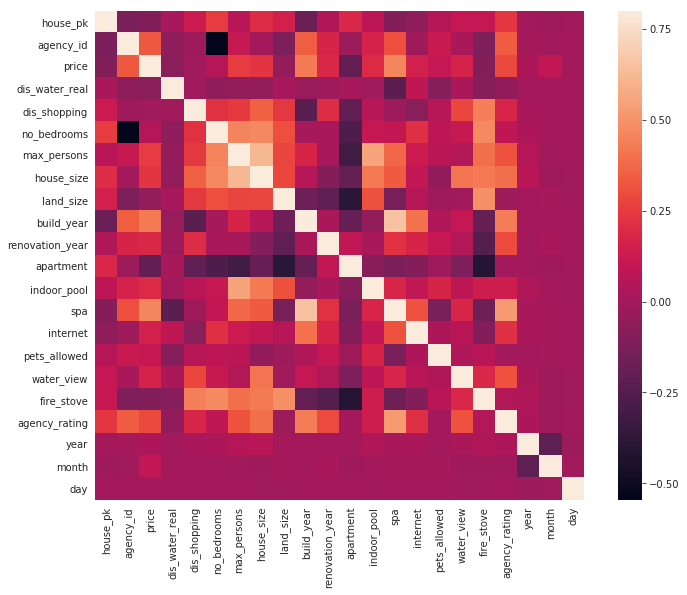

In [12]:
# correlation heatmap

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8, square=True)

#from the heatmap we can see that 'dis_water_real', 'dis_shopping', 'land_size', 'apartment', 'fire_stove' these varialbes have negative correlation with target variable 'price'

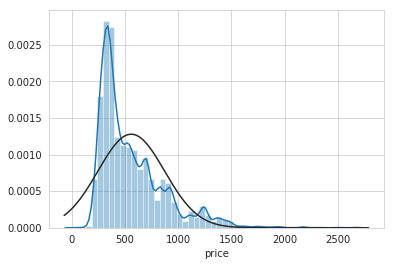

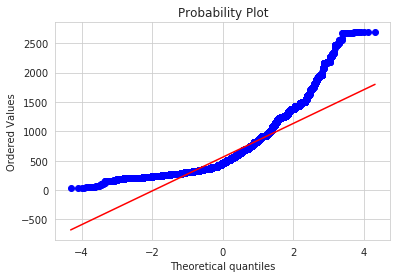

In [13]:
# now lets see the stats probability of 'price'

sb.distplot(df['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)

#from the probability plot we can see that the probability is not well fit on the regression line. In order to fit the data we can use logarithm on it.

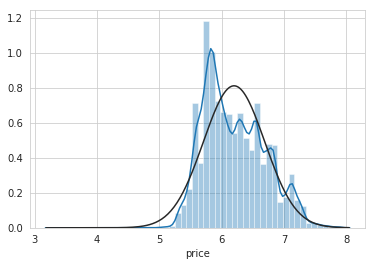

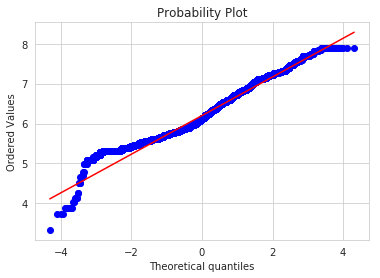

In [14]:
price = df['price'].values
df['price'] = np.log(df['price'])

sb.distplot(df['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)

# Data Preprocessing

In [15]:
# we need to convert the data between 0 to 1. We are using MinMaxScaler to do that.

scaler = MinMaxScaler(feature_range=(0,1))

#need_to_drop=['dis_water_real','dis_shopping', 'land_size', 'apartment', 'fire_stove', 'day', 'house_pk','date_in', 'price']
need_to_drop=['house_pk','date_in', 'price']

dk = df

y_data = df['price']
x_data = df.drop(need_to_drop, axis=1)
print(x_data.shape)

y_data = y_data.values
y_data = y_data.reshape(-1,1)
y_data = y_data.astype(np.float32)

x_data = x_data.values
x_data = x_data.astype(np.float32)

x_data_scaled = scaler.fit_transform(x_data)
y_data_scaled = scaler.fit_transform(y_data)

(85195, 20)


In [0]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.1, random_state=42)

# Convert the numpy data to Torch Tensor

X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test)

# Regression Class

In [0]:
class Regression(nn.Module):
    def __init__(self, input_dim):
        super(Regression, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 256)
        self.linear4 = nn.Linear(256, 64)
        self.linear5 = nn.Linear(64, 1)       
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm = nn.BatchNorm1d(64)
       
        
    def forward(self, x):
        
        out = self.relu(self.linear1(x))
        out = F.dropout(out, 0.2)
        out = self.relu(self.batch_norm1(self.linear2(out)))
        out = F.dropout(out, 0.1)
        out = self.relu(self.linear3(out))
        out = self.relu(self.batch_norm(self.linear4(out)))
        out = F.dropout(out, 0.1)
        out = self.linear5(out)
        
        return out

In [18]:
input_dim = 20

model = Regression(input_dim).to(device)
print(model)

Regression(
  (linear1): Linear(in_features=20, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# Loss function, Optimizer

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [20]:
epochs = 10000

iterr = 0
for epoch in range(epochs):
    
    
        
    X_train_torch = Variable(X_train_torch).to(device)

    y_train_torch = Variable(y_train_torch).to(device)

    optimizer.zero_grad()

    output = model(X_train_torch)

    loss = criterion(output, y_train_torch)
    
    iterr += 1
    
    if iterr % 1000 == 0:
        

        print('iter: {}, loss: {:.4f}'.format(iterr, loss.item()))

    loss.backward()

    optimizer.step()

iter: 1000, loss: 0.0035
iter: 2000, loss: 0.0024
iter: 3000, loss: 0.0018
iter: 4000, loss: 0.0014
iter: 5000, loss: 0.0011
iter: 6000, loss: 0.0008
iter: 7000, loss: 0.0007
iter: 8000, loss: 0.0006
iter: 9000, loss: 0.0006
iter: 10000, loss: 0.0006


In [21]:
#prediction

predicted = model.forward(Variable(X_test_torch).to(device)).data.cpu().numpy()

rmse = np.sqrt(mean_squared_error(predicted, y_test))

print('rmse: {:.3f}'.format(rmse))

rmse: 0.025


In [22]:
predicted_original = scaler.inverse_transform(predicted)
y_test_original = scaler.inverse_transform(y_test)

print('mean of predicted values: {:.3f}'.format(predicted_original.mean()))
print('mean of ground truth: {:.3f}'.format(y_test_original.mean()))

mean of predicted values: 6.201
mean of ground truth: 6.204


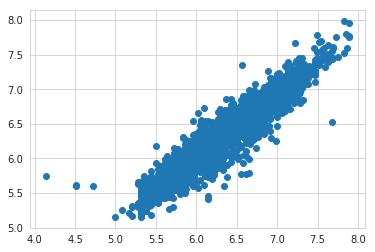

In [23]:
# scatter plot

plt.scatter(y_test_original, predicted_original)

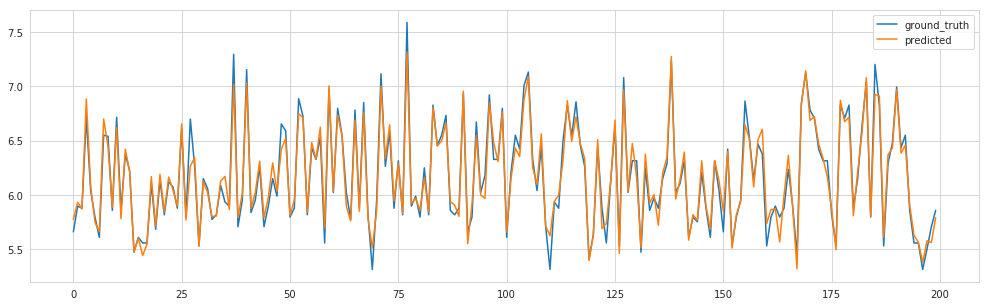

In [24]:
plt.figure(figsize=(17,5))
plt.plot(y_test_original[:200],label='ground_truth')
plt.plot(predicted_original[:200],label = 'predicted')
plt.legend()
plt.show()

In [25]:
len(predicted_original)

8520

In [26]:
type(predicted_original)

numpy.ndarray

In [27]:
np.exp(predicted_original[:5]) #predicted value

array([[322.14954],
       [376.71448],
       [354.76553],
       [977.6506 ],
       [439.38428]], dtype=float32)

In [28]:
np.rint(np.exp(y_test_original[:5])) #ground truth

#from this we can see (287, 322.14954), (364, 376.71448). Here (ground_truth, predicted value)

array([[287.],
       [364.],
       [357.],
       [826.],
       [420.]], dtype=float32)

# Forcast Future sale for one house

Here we are gonna forecast sale for '84561' house

In [29]:
house = dk[dk['house_pk']==84561]
house.head()

,house_pk,agency_id,date_in,price,dis_water_real,dis_shopping,no_bedrooms,max_persons,house_size,land_size,...,indoor_pool,spa,internet,pets_allowed,water_view,fire_stove,agency_rating,year,month,day
0,84561,0,2016-08-27,6.276643,0.261,3.0,3,4,140,726,...,0,1,1,0,1,1,3.0,0,7,26
1,84561,0,2016-08-26,6.376727,0.261,3.0,3,4,140,726,...,0,1,1,0,1,1,3.0,0,7,25
2,84561,0,2016-08-25,6.376727,0.261,3.0,3,4,140,726,...,0,1,1,0,1,1,3.0,0,7,24
3,84561,0,2016-08-24,6.376727,0.261,3.0,3,4,140,726,...,0,1,1,0,1,1,3.0,0,7,23
4,84561,0,2016-08-23,6.376727,0.261,3.0,3,4,140,726,...,0,1,1,0,1,1,3.0,0,7,22


In [30]:
house = house[['date_in','price']]
house.head()

,date_in,price
0,2016-08-27,6.276643
1,2016-08-26,6.376727
2,2016-08-25,6.376727
3,2016-08-24,6.376727
4,2016-08-23,6.376727


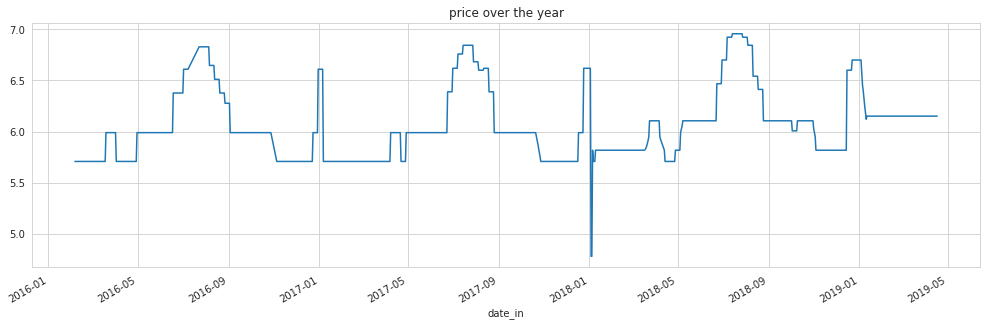

In [31]:
house_time = house.set_index('date_in')
house_time.price.plot(figsize=(17,5), title='price over the year')

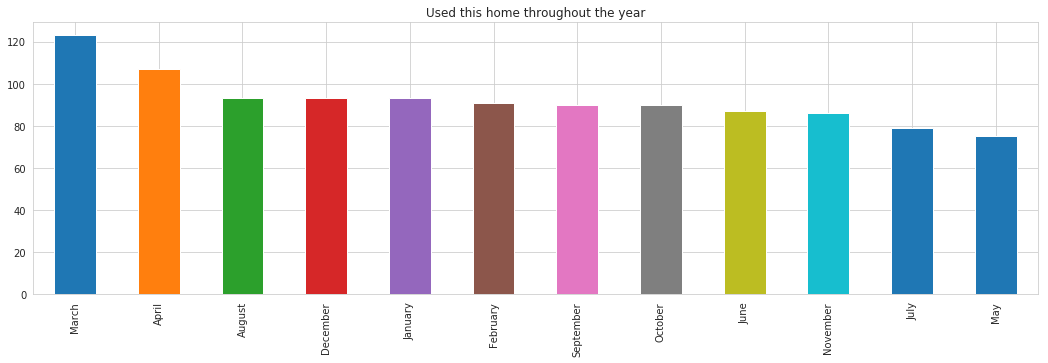

In [32]:
month_name_map = {1:'January',2:'February',3:'March', 4:'April', 5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

house_time.index.month.map(month_name_map).value_counts().plot('bar', figsize=(18,5), title = 'Used this home throughout the year')

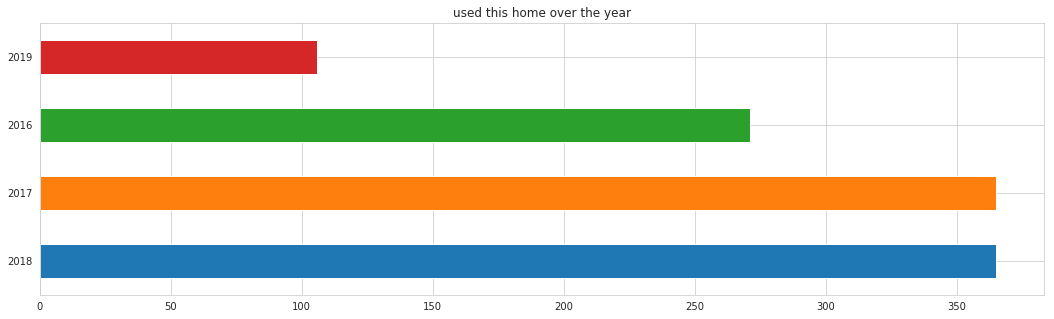

In [33]:
house_time.index.year.value_counts().plot('barh', figsize=(18,5), title='used this home over the year')

In [34]:
house.columns = ['ds','y']
house.head()

,ds,y
0,2016-08-27,6.276643
1,2016-08-26,6.376727
2,2016-08-25,6.376727
3,2016-08-24,6.376727
4,2016-08-23,6.376727


In [35]:
m = Prophet()
m.fit(house)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1467,2020-04-12
1468,2020-04-13
1469,2020-04-14
1470,2020-04-15
1471,2020-04-16


In [0]:
forecast = m.predict(future)

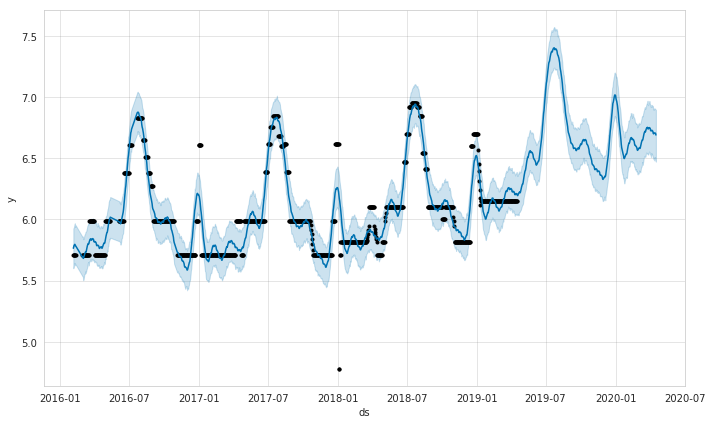

In [38]:
fig1 = m.plot(forecast)
# here the blue line represents the prediction and the black spot represents the ground truth

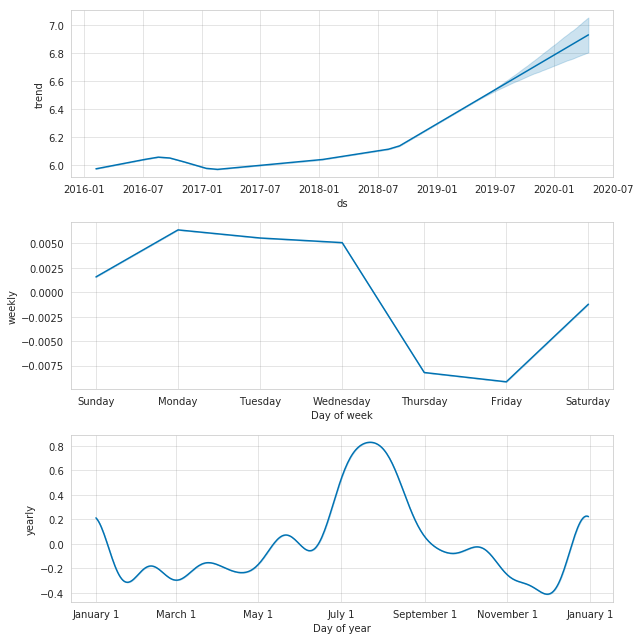

In [39]:
fig2 = m.plot_components(forecast)